# Paperbuzz analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import json

In [2]:
# Formatting options

# Matplotlib
plt.rcParams.update({
    'font.family':'sans-serif',
    'font.size': 16.0,
    'text.usetex': False,
    'figure.figsize': (11.69,8.27)
})

# Seaborn styles
sns.set_style("whitegrid")

# Pandas options
pd.options.display.float_format = '{:,.2f}'.format

## Load and process data

In [3]:
data_dir = "/home/asura/Dropbox/Shared/Juan/paperbuzz/"

### Articles with Paperbuzz  metrics

In [4]:
# Load and process articles + metrics
dtypes = {'id':str, 'doi':str, 'date':str, 'newsfeed':float, 'twitter':float, 'crossref':float,
          'wikipedia':float, 'wordpressdotcom':float, 'reddit':float, 'datacite':float,
          'cambia-lens':float, 'f1000':float, 'reddit-links':float, 'web':float, 'stackexchange':float,
          'hypothesis':float, 'article_type':str, 'is_oa':str, 'n_authors':float, 'journal_title':str, 'title':str
}
all_articles = pd.read_csv(data_dir + "paperbuzz_metrics.csv", dtype=dtypes, index_col="id")

# Change columns with metrics to integer
metrics_columns = ['newsfeed', 'twitter', 'crossref',
                   'wikipedia','wordpressdotcom', 'reddit',
                   'datacite', 'cambia-lens', 'f1000',
                   'reddit-links', 'web', 'stackexchange', 'hypothesis']
all_articles.loc[:, metrics_columns].fillna(0, inplace=True)
all_articles.loc[:, metrics_columns] = all_articles[metrics_columns].astype(int)

# Convert dates to datetimes & drop rows without date
all_articles['date'] = pd.to_datetime(all_articles['date'], errors = 'coerce')
all_articles = all_articles[~all_articles.date.isnull()]

# Extract DOI prefixes
all_articles['doi_prefix'] = all_articles.doi.map(lambda x: x[:x.find('/')])

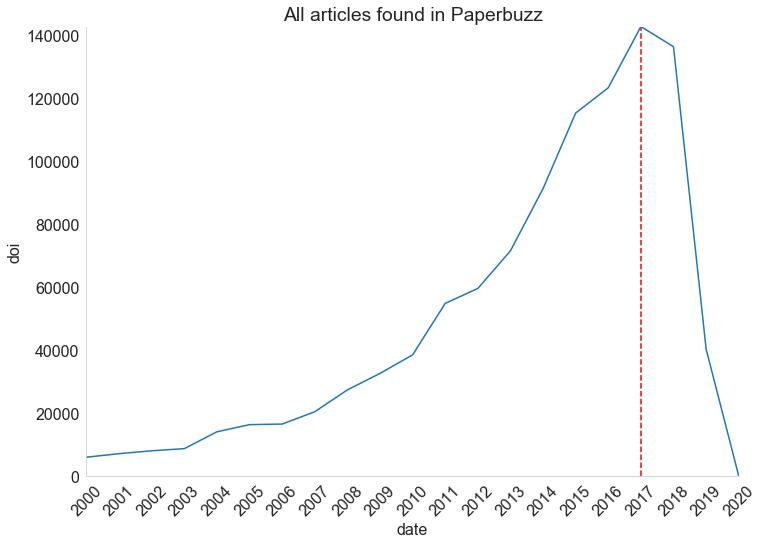

In [5]:
pdf = all_articles.groupby(all_articles["date"].dt.year)['doi'].count().to_frame()
sns.lineplot(x="date", y="doi", data=pdf.reset_index())

plt.vlines(2017, 0, pdf.max(), color="red", linestyle="--")
sns.despine()

plt.ylim(0, pdf.max().iloc[0])
plt.xlim(2000,2020)
xticks = list(range(2000,2021))
plt.xticks(xticks, xticks, rotation=45, ha="center")

plt.grid(False)

plt.title("All articles found in Paperbuzz");

In [6]:
# Limit articles to 2017
articles = all_articles[all_articles.date.between('2017-01-01', '2017-12-31')]

In [7]:
print("Articles published in 2017:", articles.doi.nunique())
print("OA:", sum(articles.is_oa=="True"))
print("Unique journal titles: ", articles.journal_title.nunique())
print("Unique DOI prefixes: ", articles.doi_prefix.nunique())

Articles published in 2017: 142739
OA: 130179
Unique journal titles:  4636
Unique DOI prefixes:  1234


### Load OJS journal metadata

In [8]:
journal_info = pd.read_csv(data_dir + "all_journals.csv")
ids_dois = pd.read_csv(data_dir + "archive_id_and_sample_doi.csv", dtype={'doi':str})
country_info = pd.read_csv(data_dir + "journals_per_country.csv")

In [9]:
# Fix region names
journal_info.replace("East Asia & Pacific (all income levels)", "East Asia & Pacific", inplace=True)

# Add DOIs by merging by archive IDs
journal_info = journal_info.merge(ids_dois, left_on="archive_id", right_on="archive_id", how="inner")

# Extract DOI prefixes
journal_info['doi_prefix'] = journal_info.doi.map(lambda x: x[:x.find('/')])

# Drop duplicate information
journal_info = journal_info.drop_duplicates(subset=["archive_id", "doi_prefix", "country", "region_name"])

# # Add region IDs
# journal_info = journal_info.merge(country_info[['archive_id', 'region_id']], left_on="archive_id", right_on="archive_id", how="left")
# journal_info = journal_info.drop_duplicates(subset=["archive_id", "doi_prefix", "country", "region_name", "region_id"])

print("Articles with unique DOI prefix/archive_id/country/region:", len(journal_info))
print("Unique archive_ids: {}".format(journal_info.archive_id.nunique()))
print("Unique DOI prefixes: {}".format(journal_info.doi_prefix.nunique()))
print("Unique countries: {}".format(journal_info.country.nunique()))
print("Unique region_names: {}".format(journal_info.region_name.nunique()))

Articles with unique DOI prefix/archive_id/country/region: 7153
Unique archive_ids: 7153
Unique DOI prefixes: 1469
Unique countries: 83
Unique region_names: 7


### Aggregate by DOI prefixes

In [44]:
# Aggregate articles by DOI prefixes
def coverage(x): 
    return len(x[x>0]) / len(x)

# Compute counts, means and coverage for doi prefixes
all_prefixes = pd.DataFrame(articles.groupby('doi_prefix')[['twitter', 'wikipedia']].agg(['mean', 'median', 'sum', coverage]))
all_prefixes.columns = ['_'.join(col) for col in all_prefixes.columns]

all_prefixes['articles_published'] = articles.groupby('doi_prefix')['doi'].count()

# Keep only those that have at least 5 articles in 2017
prefixes = all_prefixes[all_prefixes['articles_published'] >= 5]
print("Dropped {} prefixes because less than 5 articles".format(all_prefixes.index.nunique() - prefixes.index.nunique()))

Dropped 76 prefixes because less than 5 articles


In [45]:
# Merge prefixes with region names and countries
prefixes = prefixes.merge(journal_info[['doi_prefix', 'region_name', 'country']], left_index=True, right_on="doi_prefix", how="left")
prefixes = prefixes.drop_duplicates().set_index('doi_prefix')

print("Total number of prefix/country/region_name combos:", len(prefixes))
print("Unique prefixes:", prefixes.index.nunique())
print("Unique countries:", prefixes.country.nunique())
print("Unique region_names:", prefixes.region_name.nunique())

Total number of prefix/country/region_name combos: 1372
Unique prefixes: 1158
Unique countries: 78
Unique region_names: 7


In [46]:
prefixes_in_articles = prefixes.index.unique().tolist()
known_ojs_prefixes = journal_info.doi_prefix.unique().tolist()
common = set(prefixes_in_articles).intersection(set(known_ojs_prefixes))
print("Number of prefixes that we could combine with OJS metadata:", len(common))
print("DOI prefixes without geographical information:", prefixes.index.nunique()-len(common))

Number of prefixes that we could combine with OJS metadata: 948
DOI prefixes without geographical information: 210


## Results

### DOI prefix <--> country/region_name

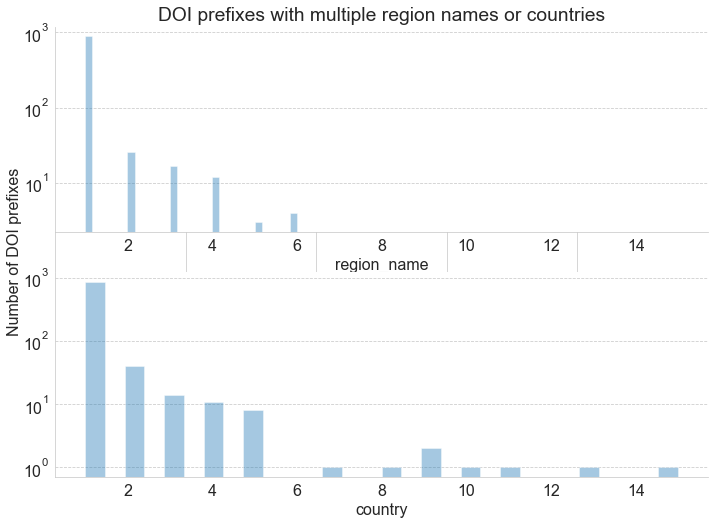

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
sns.despine(ax=ax)

for v, a in zip(["region_name", "country"], [ax1, ax2]):
    pdf = prefixes[~prefixes[v].isna()].groupby("doi_prefix")[v].nunique()
    sns.distplot(pdf, kde=False, ax=a)

    a.grid(False, axis="x")
    a.grid(axis="y", linestyle="--")
    a.set_title("")
    a.set_xlabel(v)
    a.set_yscale("log")
    sns.despine(ax=a)
    
ax.set_ylabel("Number of DOI prefixes");
ax.set_title("DOI prefixes with multiple region names or countries");

### Coverage vs means for journals

In [14]:
regions = prefixes.region_name.dropna().unique().tolist()

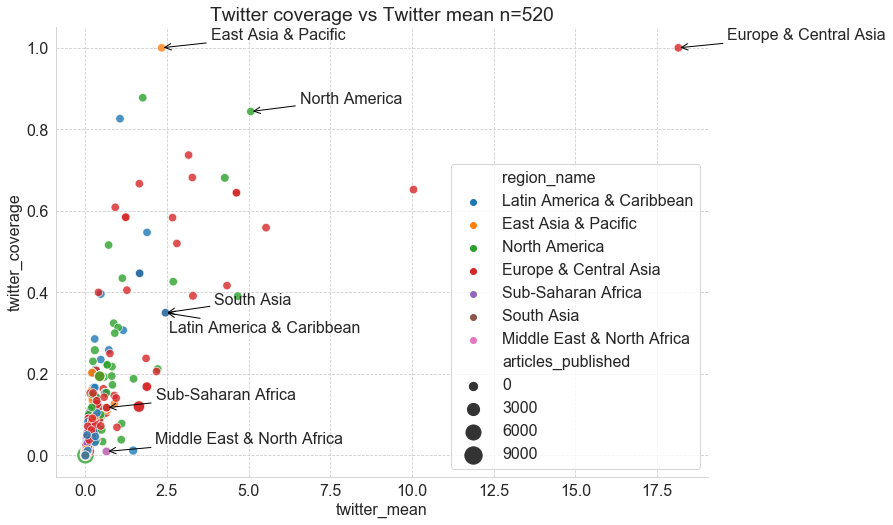

In [15]:
sns.scatterplot(x="twitter_mean", y="twitter_coverage", size="articles_published", hue="region_name", data=prefixes,
               sizes=(70, 300), alpha=.8)

for r in regions:
    i = prefixes[prefixes.region_name == r].twitter_mean.idxmax()
    if type(prefixes.loc[i]) != pd.core.series.Series:
        x = prefixes.loc[i].iloc[0]['twitter_mean']
        y = prefixes.loc[i].iloc[0]['twitter_coverage']
    else:
        x = prefixes.loc[i]['twitter_mean']
        y = prefixes.loc[i]['twitter_coverage']
    
    arrowprops = {'arrowstyle':'->', 'color':'black'}
    
    if "Carib" in r:
        plt.annotate(r, (x, y), (x+.1, y-.05), arrowprops=arrowprops)
    else:
        plt.annotate(r, (x, y), (x+1.5, y+.02), arrowprops=arrowprops)


plt.title("{} n={}".format("Twitter coverage vs Twitter mean", sum(prefixes['twitter_coverage']>0)))
sns.despine()
plt.grid(linestyle="--")

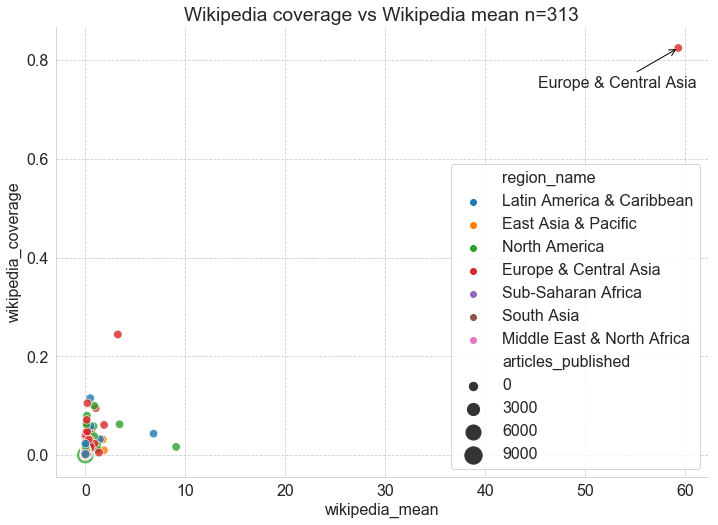

In [16]:
sns.scatterplot(x="wikipedia_mean", y="wikipedia_coverage", size="articles_published", hue="region_name", data=prefixes,
               sizes=(70, 300), alpha=.8)

# plt.xlim(0,10)
# plt.ylim(0,.25)

for r in regions:
    i = prefixes[prefixes.region_name == r].twitter_mean.idxmax()
    if type(prefixes.loc[i]) != pd.core.series.Series:
        x = prefixes.loc[i].iloc[0]['wikipedia_mean']
        y = prefixes.loc[i].iloc[0]['wikipedia_coverage']
    else:
        x = prefixes.loc[i]['wikipedia_mean']
        y = prefixes.loc[i]['wikipedia_coverage']
    
    arrowprops = {'arrowstyle':'->', 'color':'black'}
    
    if "Europe" in r:
        plt.annotate(r, (x, y), (x-14, y-.08), arrowprops=arrowprops)
    else:
        pass


plt.title("{} n={}".format("Wikipedia coverage vs Wikipedia mean", sum(prefixes['wikipedia_coverage']>0)))
sns.despine()
plt.grid(linestyle="--")

### All DOI prefixes and all metrics

In [17]:
agg_prefixes_all_metrics = pd.DataFrame(articles.groupby('doi_prefix').agg(coverage))

#### Coverage by articles vs DOI prefixes

In [18]:
df = pd.DataFrame()
df['Articles'] = 100 * articles.replace(0,np.nan).describe().loc['count'] / len(articles)
df['DOI prefixes'] = 100 * agg_prefixes_all_metrics.replace(0, np.nan).describe().loc['count'] / len(agg_prefixes_all_metrics)
df = df.drop("n_authors")

(df.round(2).sort_values(by="DOI prefixes", ascending=False)
     .style
     .background_gradient(axis=None, cmap="Greens"))

,Articles,DOI prefixes
twitter,3.06,32.25
wikipedia,0.42,17.75
wordpressdotcom,0.06,4.54
datacite,0.1,2.11
newsfeed,0.02,1.54
reddit-links,0.01,1.13
crossref,0.04,0.81
reddit,0,0.41
f1000,0,0.41
cambia-lens,0,0.16


#### Correlation of coverages

In [19]:
(agg_prefixes_all_metrics.drop(["stackexchange", "hypothesis"], axis=1).corr(method="spearman")
 .sort_values("twitter", ascending=False)
     .sort_values("twitter", ascending=False, axis=1)
     .style
     .background_gradient(axis=None, cmap="Greens")
     .format("{:.2f}")
     .set_caption("Spearman correlation ()")
)

,twitter,wikipedia,wordpressdotcom,newsfeed,reddit-links,datacite,crossref,reddit,web,f1000,cambia-lens,n_authors
twitter,1.00,0.34,0.29,0.16,0.12,0.08,0.06,0.06,0.05,0.05,0.04,-0.07
wikipedia,0.34,1.00,0.24,0.16,0.11,0.09,0.05,0.06,0.06,0.03,0.07,-0.07
wordpressdotcom,0.29,0.24,1.00,0.28,0.19,0.10,0.11,0.11,-0.01,0.05,-0.01,-0.01
newsfeed,0.16,0.16,0.28,1.00,0.23,0.16,0.14,0.10,-0.00,0.10,-0.01,-0.05
reddit-links,0.12,0.11,0.19,0.23,1.00,0.04,0.08,0.23,-0.00,-0.01,-0.00,0.03
datacite,0.08,0.09,0.10,0.16,0.04,1.00,0.11,0.08,0.19,0.08,-0.01,-0.06
crossref,0.06,0.05,0.11,0.14,0.08,0.11,1.00,-0.01,-0.00,0.28,-0.00,-0.05
reddit,0.06,0.06,0.11,0.10,0.23,0.08,-0.01,1.00,-0.00,-0.00,-0.00,-0.09
web,0.05,0.06,-0.01,-0.00,-0.00,0.19,-0.00,-0.00,1.00,-0.00,-0.00,0.01
f1000,0.05,0.03,0.05,0.10,-0.01,0.08,0.28,-0.00,-0.00,1.00,-0.00,-0.09


### Regions

#### Absolute counts of DOI prefixes per region + the number of DOI prefixes found in Twitter/Wikipedia

In [20]:
pdf = prefixes.replace(0, np.nan).groupby("region_name").agg({'twitter_coverage':'count', 'wikipedia_coverage':'count', 'articles_published':'count'})
pdf = pdf.sort_values(by="articles_published", ascending=False)
pdf = pdf.rename(columns={
    "articles_published":'total_prefixes',
    "twitter_coverage": "twitter",
    "wikipedia_coverage": "wikipedia"})
pdf['twitter_coverage'] = 100 * pdf['twitter'] / pdf['total_prefixes']
pdf['wikipedia_coverage'] = 100 * pdf['wikipedia'] / pdf['total_prefixes']

(pdf.rank(ascending=False)
    .style
    .background_gradient(cmap="Greens")
    .set_caption("Comparison of region rankings by various measures"))

,total_prefixes,twitter,wikipedia,twitter_coverage,wikipedia_coverage
region_name,,,,,
Latin America & Caribbean,1,2,2,6,5
Europe & Central Asia,2,1,1,3,1
East Asia & Pacific,3,4,4,7,7
North America,4,3,3,1,4
South Asia,5,5,5,2,3
Sub-Saharan Africa,6,6,6,4,2
Middle East & North Africa,7,7,7,5,6


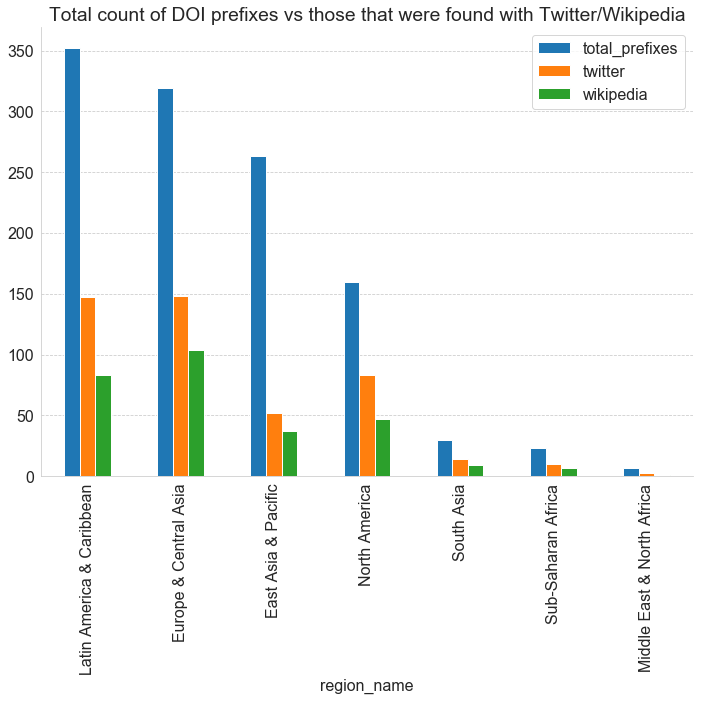

In [21]:
pdf[['total_prefixes', 'twitter', 'wikipedia']].plot(kind="bar")
plt.title("Total count of DOI prefixes vs those that were found with Twitter/Wikipedia");
sns.despine()
plt.grid(False)
plt.grid(linestyle="--", axis="y")

#### Twitter/Wikipedia coverage by regions

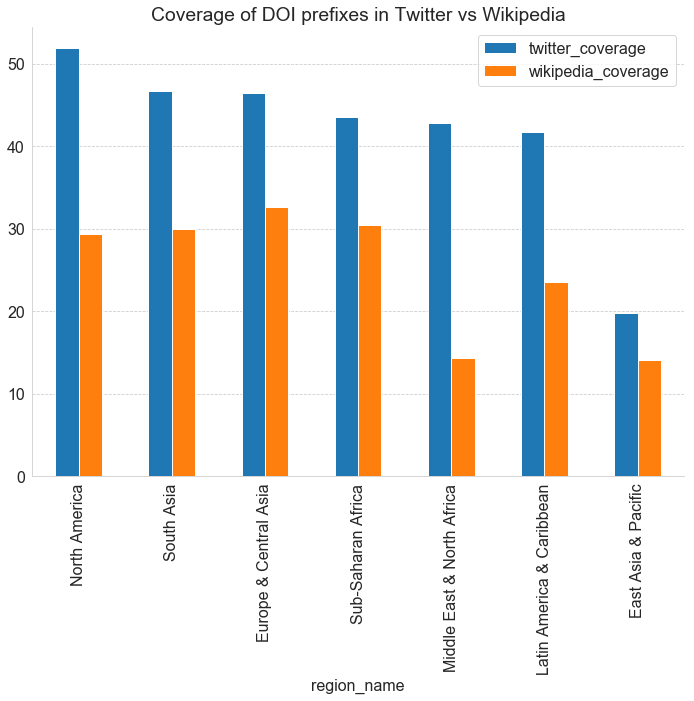

In [22]:
pdf[['twitter_coverage', 'wikipedia_coverage']].sort_values(by="twitter_coverage", ascending=False).plot(kind="bar");
plt.title("Coverage of DOI prefixes in Twitter vs Wikipedia");
sns.despine()
plt.grid(False)
plt.grid(linestyle="--", axis="y")

### Countries

In [23]:
import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = '{}/world-countries.json'.format(url)

In [24]:
pdf = prefixes.replace(0, np.nan).groupby("country").agg({'articles_published':'count',
                                                          'twitter_coverage':'count',
                                                          'wikipedia_coverage': 'count'}).reset_index()
pdf = pdf.rename(columns={'twitter_coverage':'twitter',
                          'wikipedia_coverage': 'wikipedia',
                          'articles_published':'total_prefixes'})

pdf['twitter_coverage'] = 100 * pdf['twitter'] / pdf['total_prefixes']
pdf['wikipedia_coverage'] = 100 * pdf['wikipedia'] / pdf['total_prefixes']

pdf = pdf.sort_values(by="total_prefixes", ascending=False)

pdf['country'] = pdf['country'].map(lambda x: x.upper())

#### Top 10 and bottom 10 by total prefixes

In [25]:
df = pd.concat([pdf.head(10), pdf.tail(10)])
df.index = list(range(1,11)) + list(range(len(pdf)-9, len(pdf)+1))
df

,country,total_prefixes,twitter,wikipedia,twitter_coverage,wikipedia_coverage
1,IDN,226,32,27,14.16,11.95
2,BRA,214,71,37,33.18,17.29
3,USA,114,51,32,44.74,28.07
4,COL,57,33,19,57.89,33.33
5,CAN,46,32,15,69.57,32.61
6,ESP,42,32,23,76.19,54.76
7,RUS,39,5,11,12.82,28.21
8,MEX,31,11,7,35.48,22.58
9,DEU,24,11,6,45.83,25.00
10,POL,21,11,8,52.38,38.10


#### Countries and their Twitter/Wikipedia coverages by DOI prefixes

In [26]:
m = folium.Map(location=[50, 50], zoom_start=1.8)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=pdf.reset_index(),
    columns=['country', 'total_prefixes'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of DOI prefixes'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [27]:
m = folium.Map(location=[50, 50], zoom_start=1.8)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=pdf.reset_index(),
    columns=['country', 'twitter_coverage'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Coverage of DOI prefixes on Twitter'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [28]:
m = folium.Map(location=[50, 50], zoom_start=1.8)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=pdf.reset_index(),
    columns=['country', 'wikipedia_coverage'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Coverage of DOI prefixes on Wikipedia'
).add_to(m)

folium.LayerControl().add_to(m)

m

#### Countries by weighted Twitter/Wikipedia counts

In [48]:
pdf = prefixes.groupby("country").apply(lambda x: np.average(x['twitter_mean'], weights=x['articles_published'])).to_frame("Weighted Twitter Mean")
pdf['Weighted Wiki Mean'] = prefixes.groupby("country").apply(lambda x: np.average(x['wikipedia_mean'], weights=x['articles_published']))
pdf['tweets_sum'] = prefixes.groupby("country")['twitter_sum'].sum()

pdf = pdf.reset_index()
pdf['country'] = pdf.country.map(lambda x: x.upper())

In [49]:
m = folium.Map(location=[50, 50], zoom_start=1.8)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=pdf.reset_index(),
    columns=['country', 'tweets_sum'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sum of tweets'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [30]:
m = folium.Map(location=[50, 50], zoom_start=1.8)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=pdf.reset_index(),
    columns=['country', 'Weighted Twitter Mean'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average tweets weighter by Journal publication count'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [31]:
m = folium.Map(location=[50, 50], zoom_start=1.8)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=pdf.reset_index(),
    columns=['country', 'Weighted Wiki Mean'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average tweets weighter by Journal publication count'
).add_to(m)

folium.LayerControl().add_to(m)

m